<a href="https://colab.research.google.com/github/sliu-ualbany/ualbany-ece-451-551-552/blob/main/course_project_robot_controller.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Two-Link Robot Arm Kinematics

> Adapted from Purdue 2021 Spring CS 593 course


Through this course project, you will:
- Get familiar and comfortable with coding in Python 
- Learn how to use Jupyter Notebook / Google Colab
- Learn how to use MuJoCo (Multi-Joint dynamics with Contact): a popular robot simulator
- Translate textbook knowledge towards practical use
- Basic Robot Kinematics (forward kinematics, inverse kinematics)
- Basic Robot Control (PD control)


## Getting Started

We'll be using OpenAI gymnasium to model the robot's environment.
- [OpenAI gymnasium](https://gymnasium.farama.org) is a toolkit for developing planning and control algorithms. It provides a standard API that abstracts away the model of the robot's environment. It is primarily used for reinforcement learning agents, but can work with any controller, including the PD controllers you'll build in this assignment.
  - If you've never used gym, be sure to read this short [tutorial](https://gym.openai.com/docs/) before getting started.


## Installation Instructions
Before running this notebook, you'll need to install `gymnasium`

In [ ]:
%pip install gymnasium[mujoco]

In [ ]:
#@title Check if installation was successful + Setup mujoco

from google.colab import files

import distutils.util
import subprocess
if subprocess.run('nvidia-smi').returncode:
  raise RuntimeError(
      'Cannot communicate with GPU. '
      'Make sure you are using a GPU Colab runtime. '
      'Go to the Runtime menu and select Choose runtime type.')
# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl

try:
  print('Checking that the installation succeeded:')
  import mujoco
  mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')

print('Installation successful.')

In [ ]:
#@title Import packages for plotting and creating graphics
import time
import itertools
import numpy as np
from typing import Callable, NamedTuple, Optional, Union, List

# Graphics and plotting.
print('Installing mediapy:')
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy
import mediapy as media
import matplotlib.pyplot as plt

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

### Reacher Environment Introduction

The robot arm you will be controlling looks like this:

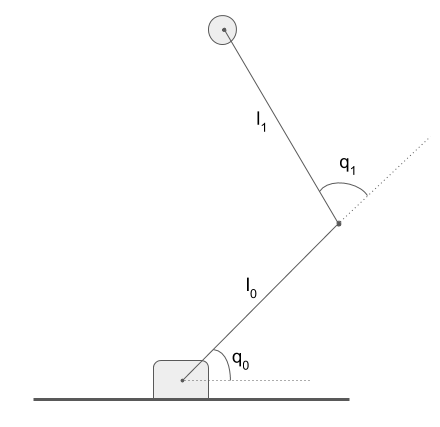

The base of the robot is at the origin; the links $l_0$ and $l_1$ are 0.1 and 0.11 units long respectively.

The action space of environment is [$\tau_0$,$\tau_1$], where $\tau_0$ and $\tau_1$ are the torques applied to joints $q_0$ and $q_1$ respectively.

In [ ]:
# load libraries (if this fails, see "Installation Instructions")
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# initialize the environment
env = gym.make("Reacher-v4",render_mode="rgb_array")

observation, info = env.reset()
media.show_image(env.render())

Your job is to implement PD controllers that track the trajectory

$$\begin{bmatrix}x(\theta) \\ y(\theta)\end{bmatrix}
= \begin{bmatrix}(0.19 + 0.02 \cos 4\theta)\cos\theta \\ (0.19 + 0.02 \cos 4\theta)\sin\theta\end{bmatrix},
\text{ for }\theta \in [-\pi, \pi]$$

This trajectory is plotted below:

In [ ]:
x = [(0.19 + 0.02 * np.cos(theta * 4)) * np.cos(theta) for theta in np.arange(-np.pi, np.pi, 0.001)]
y = [(0.19 + 0.02 * np.cos(theta * 4)) * np.sin(theta) for theta in np.arange(-np.pi, np.pi, 0.001)]
plt.plot(x, y)
plt.axis('equal')
# plt.show()
plt.savefig('arm_traj.png')
traj = list(zip(x,y))
print(traj[0])

## What you need to do

### 1. Forward Kinematics

Derive the forward model for the robot as a closed-form expression expressed in joint angles and link length:

$$f\left(\begin{bmatrix}q_0 \\ q_1\end{bmatrix}\right) =
\begin{bmatrix}
% your answer here
\underline{\;\;\;\;} \\
\underline{\;\;\;\;}
\end{bmatrix}
= \begin{bmatrix} x \\ y\end{bmatrix}$$

Using the robot model parameters, write a function `getForwardModel` that takes the joint states and returns the end-effector position.

In [ ]:
l0 = 0.1
l1 = 0.11
def getForwardModel(q0, q1):
    # WRITE YOUR CODE HERE
    
    return np.array([x,y])

In [ ]:
# TEST CODE to help you validate your Forward Kinematics Model

# resets env
obs, info = env.reset()
q0,q1 = np.pi,0

# sets initial state of env
env.set_state(np.array([q0,q1,0,0]),np.array([0,0,0,0]))
q0, q1 = env.data.qpos[:2]
xy = getForwardModel(q0,q1) # predicted xy from forward model

torq = np.array([0,0])
obs = env.step(torq)

xy_exp = obs[0][8:-1] # get actual xy
assert np.allclose(xy_exp,xy)

media.show_image(env.render())

### 2. Jacobian

Derive the expression for the Jacobian of the robot:

$$J_f(q_0, q_1) = \begin{bmatrix}
\underline{\;\;\;\;} % your answer here
\end{bmatrix}$$

Write a function `getJacobian` that takes the joint states and returns the Jacobian.

In [ ]:
def getJacobian(q0, q1):
    # WRITE YOUR CODE HERE

    return np.array([jacX,jacY])

### 3. PD Controller

**Background:** From the class on Jacobians, we learned about,
$$\vec \tau = J^T \vec F,$$
where
- $\vec F = \langle F_x, F_y \rangle$ is the force vector exerted by the robot at the end effector
- $\vec \tau = \langle \tau_0, \tau_1 \rangle$ is the vector of torques exerted by the joints
- $J$ is the Jacobian matrix at the current position.

Use this fact to implement a *closed-loop PD controller* that controls the robot along the trajectory `traj`, using the error in the end-effector as the input signal. Your controller should compute forces $F_x$ and $F_y$, and then use `getJacobian` along with the above equation to translate them into joint torques.

Plot the trajectory of the robot over the desired trajectory, and calculate the mean square error between both paths. Also plot the errors with respect to time, and use those plots to tune your controller.

**Note: Initialize the robot arm to $q_0=\pi$ and $q_1=0$**

#### PD Controller Introduction

##### Introduction
A Proportional-Derivative (PD) controller is used in control systems to regulate the output by considering both the present and the future error between the desired and actual system states.

##### Mathematical Formulation
The control input $u(t)$ of a PD controller is given by:

$$
u(t) = K_p \cdot e(t) + K_d \cdot \frac{d}{dt}e(t)
$$

where:

- $u(t)$ is the control input at time $t$.
- $K_p$ is the proportional gain.
- $K_d$ is the derivative gain.
- $e(t)$ is the error at time $t$, defined as $e(t) = \text{Setpoint} - \text{Process Value}$.
- $\frac{d}{dt}e(t)$ is the rate of change of error with respect to time.

##### Proportional Control ($K_p$)
The proportional term produces an output value that is proportional to the error $e(t)$. The proportional response can be adjusted by multiplying the error by a constant $K_p$.

##### Derivative Control ($K_d$)
The derivative term anticipates future error by considering its rate of change. It provides a control output to counteract the rate of error change.

##### Advantages
The PD controller combines the advantages of both Proportional and Derivative control actions, making the system more stable and quicker to reach the setpoint without introducing integral action, which can lead to overshoot.


In [ ]:
class PID:
    def __init__(self,Kp,Kd):
        self.Kp = Kp
        self.Kd = Kd
        self.e = 0
        self.prev_error = 0

    def calculate(self,curr,setp):
        # WRITE YOUR CODE HERE
       
        return  # DEFINE YOUR RETURN

Kp = np.diag(np.array([10,10]))         # experiment and tune your Kp parameter
Kd = np.diag(np.array([0.1,0.1]))       # experiment and tune your Kd parameter
ctrl = PID(Kp,Kd)

q0,q1 = np.pi,0

curr_plt = np.zeros((len(traj),2))

# resets env
obs, info = env.reset()

# sets initial state of env
env.set_state(np.array([q0,q1,0,0]),np.array([0,0,0,0]))

# frames for video
frames = []

for t in range(len(traj)):
    q0, q1 = env.data.qpos[:2] # current joint angles
    xy = getForwardModel(q0,q1) # current end effector position

    # WRITE YOUR CODE HERE
    # Use the PD controller to return cartesian force <Fx, Fy>
    # Use getJacobian to calculate Jacobian for current joint angles
    # Calculate torque (torq) using the force-Jacobian relationship

    env.step(torq) # step with action
    curr_plt[t] = xy # adds current position to list for display
    frames.append(env.render()) # rendering

duration = 3.8  # (seconds)
framerate = 60  # (Hz)
media.show_video(frames, fps=framerate)

plt.axis('equal')
plt.plot(curr_plt[:,0],curr_plt[:,1])
plt.plot(x,y)
plt.show()

t = np.arange(len(traj))
err_x = curr_plt[:,0] - x
err_y = curr_plt[:,1] - y
plt.plot(t,err_x)
plt.show()

plt.plot(t,err_y)
plt.show()
mse_x = (err_x ** 2).mean(axis=None)
mse_y = (err_y ** 2).mean(axis=None)
print("MSE_x: {}".format(mse_x))
print("MSE_y: {}".format(mse_y))
print("MSE: {}".format(mse_y + mse_x))

### 4. Inverse Kinematics

#### Jacobian-Based Inverse Kinematics

##### Introduction
Jacobian-based inverse kinematics aims to find the joint angles in a robot manipulator that result in a specific end-effector position. It iteratively refines the joint angles using the Jacobian matrix to minimize the error between the current and target end-effector positions.

##### Algorithm Overview
The code snippet employs an iterative approach to find the joint angles `q` that minimize the error `err` between the end-effector's current and target positions. The algorithm uses the pseudo-inverse of the Jacobian matrix `J` to adjust `q`.

##### Variables

- `err`: Error term, initialized to $\infty$.
- `q`: Current joint angles.
- `eps`: Error tolerance.
- `d_x`: Deviation of the end-effector's current position from the target.
- `J`: Jacobian matrix, calculated from `q`.
- `pseudo_inv`: Pseudo-inverse of `J`.
- `q_err`: Change in `q` to minimize `err`.
- `max_iter`: Maximum number of iterations.

##### Steps

1. **Initialization**: Initialize `err` to $\infty$, `q` to `current_state`, and `eps` to a small value (0.001).

2. **Iteration Loop**: Iterate until `err` is smaller than `eps` or maximum iterations reached (`max_iter`).
    - Calculate the deviation `d_x` between the current end-effector position and the target.
    - Compute the Jacobian matrix `J`.
    - **Singularity Handling**: If $\text{det}(J) < \text{eps}$, slightly perturb `q` and recalculate `J`.
    - Calculate the pseudo-inverse `pseudo_inv` of `J`.
    - Compute the change `q_err` needed in `q` to reduce `err`.
    - Update `q` by subtracting `q_err`.
    - Update `err` as the norm of `q_err`.

3. **Result**: Return the final joint angles `q`.



Using the functions `getForwardModel` and `getJacobian` from previous sections, write a function `getIK` that takes the current end-effector position, target end-effector position, and current joint states; and returns the target joint-states.

Note: remember to account for singularity in your Inverse Kinematics function.

In [ ]:
def getIK(target_position, current_state):
    err = np.inf
    q = current_state.copy()
    # WRITE YOUR CODE HERE
    # Follow the algorithm above

    return q

Use the above closed-loop PD controller to control the robot along the trajectory `traj`, using the error in the joint-angles as the input signal.

Plot the trajectory of the robot over the actual trajectory and caluclate the mean square error between both paths. Also plot the errors with respect to time, and use those plots to tune your controller.

**Note: Initialize the robot arm to $q_0=\pi$ and $q_1=0$**

In [ ]:
# PD Controller
Kp = np.diag(np.array([1,1]))   # experiment and tune your Kp parameter
Kd = np.diag(np.array([2,2]))   # experiment and tune your Kd parameter
ctrl_ik = PID(Kp,Kd)            # PD controller for inverse kinematics

# robot initial joint angles
q0,q1 = np.pi,0

# initialize current position array
curr_plt = np.zeros((len(traj),2))

# resets env
obs, info = env.reset()

# sets initial state of env
env.set_state(np.array([q0,q1,0,0]),np.array([0,0,0,0]))

# frames for video
frames = []

for t in range(len(traj)):
    q0, q1 = env.data.qpos[:2] # current joint angles
    desired_xy = traj[t]
    # WRITE YOUR CODE HERE
    # use getIK and PD controller to return joint torques: torq

    env.step(torq) # step with action
    curr_plt[t] = getForwardModel(q0,q1) # adds current position to list for display
    frames.append(env.render()) # rendering

duration = 3.8  # (seconds)
framerate = 60  # (Hz)
media.show_video(frames, fps=framerate)

plt.axis('equal')
plt.plot(curr_plt[:,0],curr_plt[:,1])
plt.plot(x,y)
plt.show()

t = np.arange(len(traj))
err_x = curr_plt[:,0] - x
err_y = curr_plt[:,1] - y
plt.plot(t,err_x)
plt.show()

plt.plot(t,err_y)
plt.show()
mse_x = (err_x ** 2).mean(axis=None)
mse_y = (err_y ** 2).mean(axis=None)
print("MSE_x: {}".format(mse_x))
print("MSE_y: {}".format(mse_y))
print("MSE: {}".format(mse_y + mse_x))